# Capstone Project - The Battle of the Neighborhoods

### Applied Data Science Capstone by IBM/Coursera

* **Name: Boyan Botev**

* **Date: 4/24/2019**

## Table of contents
* [Introduction/Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction/Business Problem <a name="introduction"></a>

The City of Charlotte has experienced a lot of growth in population, construction and business development in the recent years. In this paper I will perform segmentation analysis of the City of Charlotte, North Carolina for the purposes of understanding the composition of different venues near clusters of households with different characteristics. We'll examine clusters based on just two of several other possible metrics to gain better understanding of some of the charachteristics of the Queen city. 

The target audience for this report would be a business trying to find a location to open or relocate to or even the city of Charlotte which could incentivize certain businesses to come to neighborhoods where they would not typically go on their own for the purposes of creating greater diversity. 

## Data <a name="data"></a>

For this project I will be using data provided by the City fo Charlotte. The webite where the data resides is located at  http://data.charlottenc.gov/. I will be using two data sets from there, namely the Census Population Block Groups and the Census Household Income Block Groups. The first set  has the Longitude and Latitude of each Census Block Group and the second set contains demographic and income data for each block. A Census Block Group is defined as the smallest geographical unit for which the US Census Bureau publishes data. Typically, there are 600 to 3000 households per block group, but as we'll see later on this is not always the case.

In addition to the census location, demographic and income data described above, I will be collecting venues data using the Foursquare API and enriching the data set provided by the City of Charlotte. In this paper we'll mainly focus on the median income per Census Block Group, the population density per square mile and the venue category obtained by the Foursquare API.

#### First import libraries

In [1]:
import pandas as pd
import numpy as np
import json

from bs4 import BeautifulSoup
import requests

from geopy.geocoders import Nominatim 
import folium 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

mpl.style.use('ggplot')

In [2]:
%matplotlib inline 

#### Download the KML file showing the Census Block Groups and their locations from Charlotte Open Data portal:

http://data.charlottenc.gov/datasets/1d6040c72a5e4fee91e8fa1f8d1c5cc3_11/data

#### Download income data for each Census Block Group

http://data.charlottenc.gov/datasets/census-household-income-block-groups

### Preprocess the Census Block Groups. 
We'll need the Longitude and Latitude for each block and later join to the income data

In [3]:
with open('Census_Block_Groups.kml', 'r') as f:
    soup = BeautifulSoup(f, 'xml')

Extract the column names from the dataset 

In [4]:
s = ""
for sd in soup.find_all('SimpleField'):
    s = s + sd.attrs['name'] + ","
cols = s.split(",")
cols.pop()
print(cols)
print("Length: {}".format(len(cols)))

['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10', 'NAMELSAD10', 'ALAND10', 'AWATER10', 'Latitude', 'Longitude', 'Population', 'White', 'African_American', 'AmerIn_AlaskaNative', 'Asian', 'NatHawaiian_PacIslander', 'Some_other_race', 'Two_or_more_races', 'Hispanic', 'Housing_Units', 'Occupied_Housing_Units', 'Vacant_Housing_Units', 'Occupancy_Rate', 'Percent_White', 'Percent_African_American', 'Percent_Asian', 'Percent_Hispanic', 'Pop_SqMi', 'SqMi', 'ShapeSTArea', 'ShapeSTLength']
Length: 32


Build empty frame

In [5]:
df = pd.DataFrame(columns=cols)
df

Empty DataFrame
Columns: [OBJECTID, STATEFP10, COUNTYFP10, TRACTCE10, BLKGRPCE10, GEOID10, NAMELSAD10, ALAND10, AWATER10, Latitude, Longitude, Population, White, African_American, AmerIn_AlaskaNative, Asian, NatHawaiian_PacIslander, Some_other_race, Two_or_more_races, Hispanic, Housing_Units, Occupied_Housing_Units, Vacant_Housing_Units, Occupancy_Rate, Percent_White, Percent_African_American, Percent_Asian, Percent_Hispanic, Pop_SqMi, SqMi, ShapeSTArea, ShapeSTLength]
Index: []

[0 rows x 32 columns]

Let's put the data in the frame 

In [6]:
sd = soup.find_all('SimpleData')
i = 0

while i < len(sd):
    row = []
    for col in cols:
        #print(col)
        if i >= len(sd):
            row.append('0')
        elif col == sd[i].attrs['name']:
            row.append(sd[i].contents[0])
        else:
            row.append('0')
            i=i-1
        i=i+1
        
    df = df.append(pd.DataFrame([row],columns=cols),ignore_index=True)

In [7]:
df.head()

OBJECTID STATEFP10 COUNTYFP10 TRACTCE10 BLKGRPCE10       GEOID10  \
0        1        37        119    005301          1  371190053011   
1        2        37        119    001400          2  371190014002   
2        3        37        119    001200          3  371190012003   
3        4        37        119    005847          1  371190058471   
4        5        37        119    000700          1  371190007001   

      NAMELSAD10  ALAND10 AWATER10    Latitude        ...         \
0  Block Group 1  3692032        0  35.2582845        ...          
1  Block Group 2  1051009        0  35.2437169        ...          
2  Block Group 3  2111630     6882   35.227408        ...          
3  Block Group 1  2937830    19993  35.0855266        ...          
4  Block Group 1  1271722        0   35.238594        ...          

  Vacant_Housing_Units Occupancy_Rate Percent_White Percent_African_American  \
0                  121     0.89523809    0.19183829               0.55034324   
1                  105           0.86    0.76124031               0.15813953   
2                   62     0.92521109    0.88888888               0.06272401   
3                   27     0.94104803    0.93048576               0.01256281   
4                   70     0.84198645    0.39130434               0.50271739   

  Percent_Asian Percent_Hispanic       Pop_SqMi        SqMi       ShapeSTArea  \
0    0.02784134       0.29099923  1839.82774992  1.42513341  39730439.0307617   
1    0.03798449       0.05193798  3179.74748584  0.40569259  11310060.2045898   
2    0.01911589       0.03584229  2047.08445784  0.81774838  22797516.5803833   
3    0.03266331       0.02512562  1045.77652705  1.14173532  31829754.0740967   
4    0.08152173       0.02581521  1499.32745237  0.49088676   13685137.831604   

      ShapeSTLength  
0  27948.1327747263  
1  17806.0105455178  
2  22242.7348192012  
3  24818.7360669474  
4   23242.269832404  

[5 rows x 32 columns]

In [8]:
df.shape

(555, 32)

Drop unnecessary columns

In [9]:
df.drop(['OBJECTID','STATEFP10','COUNTYFP10','TRACTCE10','BLKGRPCE10','NAMELSAD10','ALAND10','AWATER10','ShapeSTArea','ShapeSTLength'], axis=1, inplace=True)

In [10]:
df

GEOID10    Latitude    Longitude Population White African_American  \
0    371190053011  35.2582845  -80.8060757       2622   503             1443   
1    371190014002  35.2437169  -80.8024062       1290   982              204   
2    371190012003   35.227408  -80.7930404       1674  1488              105   
3    371190058471  35.0855266  -80.7642117       1194  1111               15   
4    371190007001   35.238594  -80.8190269        736   288              370   
5    371190001001  35.2255892  -80.8490392        334   285               29   
6    371190025002   35.218428  -80.8258117        665   584               53   
7    371190020035    35.15328  -80.7525771       1100   487              495   
8    371190057091  35.1279682  -80.6947191       1506  1218              123   
9    371190019182  35.1964659  -80.7552813       1725   523              916   
10   371190032011  35.1888304  -80.8695642       1129   692               69   
11   371190031021  35.1507457  -80.8551112       1761  1421              211   
12   371190058172  35.0697703  -80.7810902       2829  2506              115   
13   371190057151  35.2089774  -80.5900111       2526  2285               94   
14   371190056211  35.2473186  -80.6459136       2980  1770              946   
15   371190057162  35.1708129  -80.7158804       2656  1213              881   
16   371190018013  35.2070456  -80.7936017        587   237              297   
17   371190022003  35.1761471  -80.8064703        946   915               17   
18   371190058171  35.0811971  -80.7791622       1172  1068               35   
19   371190037002  35.2030473  -80.8760992       1204    29             1119   
20   371190030061   35.138038  -80.8295891       1599  1531               22   
21   371190058313   35.085079  -80.8493397        317   262               35   
22   371190022004  35.1831936  -80.8126767       1662  1505               87   
23   371190055242  35.3114081  -80.7846415       1259   215              385   
24   371190060062  35.2725518  -80.9585192       1787   680              882   
25   371190062092  35.4476273  -80.8877246       1500  1259              150   
26   371190062091  35.4587443  -80.8805861        464   419               26   
27   371190062093  35.4505892  -80.8757168       1862  1629              124   
28   371190058332  35.1060535  -80.7405792       2478  2208               60   
29   371190059061  35.2367769  -81.0013011       1657  1113              340   
..            ...         ...          ...        ...   ...              ...   
525  371190015073  35.2401697  -80.7402137       1405   146             1093   
526  371190059131  35.1441241  -80.9704877       1634   610              632   
527  371190012001  35.2272666  -80.7825628       2422   918              611   
528  371190011001   35.217061  -80.8048153        546   477               50   
529  371190019102  35.1937986  -80.7381451       1381   446              638   
530  371190036004  35.2197121  -80.8771654        768    48              690   
531  371190058481   35.092716  -80.7457844       2443  2033              113   
532  371190058112  35.1348329  -80.7490994       1612  1410              104   
533  371190053051  35.2715438  -80.7918133        908    64              740   
534  371190059132  35.1403219  -80.9525947       2989  1467              778   
535  371190022002  35.1815697  -80.7957128        945   854               42   
536  371190039021  35.2138391  -80.9087099       1121    33             1016   
537  371190019232  35.2143458  -80.7117071       1217   427              536   
538  371190019222   35.215614  -80.6961374       2518   764             1251   
539  371190013002  35.2378819  -80.7947406       1016   332              501   
540  371190056181  35.2670087  -80.6861189       1635  1103              363   
541  371190015082  35.2382073  -80.7271806       2565   945             1276   
542  371190036003  35.2134522  -80.8814179        935    34              867   
543  37119

### Now Preprocess the Census Household Income Block Groups. 

In [11]:
with open('Census_Household_Income_Block_Groups.kml', 'r') as f:
    soup = BeautifulSoup(f, 'xml')

In [12]:
s = ""
for sd in soup.find_all('SimpleField'):
    s = s + sd.attrs['name'] + ","
cols = s.split(",")
cols.pop()
print(cols)
print("Length: {}".format(len(cols)))

['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10', 'NAMELSAD10', 'LOGRECNO', 'geoname', 'Total_Households', 'Less_than_10000', 'i10000_to_14999', 'i15000_to19999', 'i20000_to_24999', 'i25000_to_29999', 'i30000_to_34999', 'i35000_to_39999', 'i40000_to_44999', 'i45000_to_49999', 'i50000_to_59999', 'i60000_to_74999', 'i75000_to_99999', 'i100000_to_124999', 'i125000_to_149999', 'i150000_to_199999', 'i200000_or_more', 'Median_Household_Income', 'TotalFamilies', 'FamiliesInPoverty', 'FamilyPovertyRate', 'SHAPESTArea', 'SHAPESTLength']
Length: 32


In [13]:
df_income = pd.DataFrame(columns=cols)

In [14]:
sd = soup.find_all('SimpleData')
i = 0

while i < len(sd):
    row = []
    for col in cols:
        #print(col)
        if i >= len(sd):
            row.append('0')                 # we'll assume 0 for missing data 
        elif col == sd[i].attrs['name']:
            row.append(sd[i].contents[0])
        else:
            row.append('0')                 # we'll assume 0 for missing data
            i=i-1
        i=i+1
        
    df_income = df_income.append(pd.DataFrame([row],columns=cols),ignore_index=True)

In [15]:
df_income.drop(['OBJECTID','STATEFP10','COUNTYFP10','TRACTCE10','BLKGRPCE10','NAMELSAD10','SHAPESTArea','SHAPESTLength','LOGRECNO'], axis=1, inplace=True)
df_income

GEOID10                                            geoname  \
0    371190035001  Block Group 1, Census Tract 35, Mecklenburg Co...   
1    371190040003  Block Group 3, Census Tract 40, Mecklenburg Co...   
2    371190059071  Block Group 1, Census Tract 59.07, Mecklenburg...   
3    371190057111  Block Group 1, Census Tract 57.11, Mecklenburg...   
4    371190048002  Block Group 2, Census Tract 48, Mecklenburg Co...   
5    371190058481  Block Group 1, Census Tract 58.48, Mecklenburg...   
6    371190015091  Block Group 1, Census Tract 15.09, Mecklenburg...   
7    371190056181  Block Group 1, Census Tract 56.18, Mecklenburg...   
8    371190018013  Block Group 3, Census Tract 18.01, Mecklenburg...   
9    371190015042  Block Group 2, Census Tract 15.04, Mecklenburg...   
10   371190060062  Block Group 2, Census Tract 60.06, Mecklenburg...   
11   371190006001  Block Group 1, Census Tract 6, Mecklenburg Cou...   
12   371190020021  Block Group 1, Census Tract 20.02, Mecklenburg...   
13   371190055092  Block Group 2, Census Tract 55.09, Mecklenburg...   
14   371190029052  Block Group 2, Census Tract 29.05, Mecklenburg...   
15   371190031021  Block Group 1, Census Tract 31.02, Mecklenburg...   
16   371190016092  Block Group 2, Census Tract 16.09, Mecklenburg...   
17   371190031091  Block Group 1, Census Tract 31.09, Mecklenburg...   
18   371190064052  Block Group 2, Census Tract 64.05, Mecklenburg...   
19   371190027021  Block Group 1, Census Tract 27.02, Mecklenburg...   
20   371190030131  Block Group 1, Census Tract 30.13, Mecklenburg...   
21   371190001004  Block Group 4, Census Tract 1, Mecklenburg Cou...   
22   371190058151  Block Group 1, Census Tract 58.15, Mecklenburg...   
23   371190040001  Block Group 1, Census Tract 40, Mecklenburg Co...   
24   371190057131  Block Group 1, Census Tract 57.13, Mecklenburg...   
25   371190019211  Block Group 1, Census Tract 19.21, Mecklenburg...   
26   371190038072  Block Group 2, Census Tract 38.07, Mecklenburg...   
27   371190058313  Block Group 3, Census Tract 58.31, Mecklenburg...   
28   371190061091  Block Group 1, Census Tract 61.09, Mecklenburg...   
29   371190057132  Block Group 2, Census Tract 57.13, Mecklenburg...   
..            ...                                                ...   
525  371190019192  Block Group 2, Census Tract 19.19, Mecklenburg...   
526  371190064041  Block Group 1, Census Tract 64.04, Mecklenburg...   
527  371190011001  Block Group 1, Census Tract 11, Mecklenburg Co...   
528  371190055232  Block Group 2, Census Tract 55.23, Mecklenburg...   
529  371190060104  Block Group 4, Census Tract 60.10, Mecklenburg...   
530  371199803001  Block Group 1, Census Tract 9803, Mecklenburg ...   
531  371190058171  Block Group 1, Census Tract 58.17, Mecklenburg...   
532  371190020042  Block Group 2, Census Tract 20.04, Mecklenburg...   
533  371190031023  Block Group 3, Census Tract 31.02, Mecklenburg...   
534  371190058281  Block Group 1, Census Tract 58.28, Mecklenburg...   
535  371190059062  Block Group 2, Census Tract 59.06, Mecklenburg...   
536  371190018011  Block Group 1, Census Tract 18.01, Mecklenburg...   
537  371190056203  Block Group 3, Census Tract 56.20, Mecklenburg...   
538  371190060082  Block Group 2, Census Tract 60.08, Mecklenburg...   
539  371190030075  Block Group 5, Census Tract 30.07, Mecklenburg...   
540  371190030163  Block Group 3, Census Tract 30.16, Mecklenburg...   
541  371190019121  Block Group 1, Census Tract 19.12, Mecklenburg...   
542  371190019182  Block Group 2, Census Tract 19.18, Mecklenburg...   
543  371190062152  Block Group 2, Census Tract 62.15, Mecklenburg...   
544  371190058452  Block Group 2, Census Tract 58.45, Mecklenburg...   
545  371190051002  Block Group 2, Census Tract 51, Mecklenburg Co...   
546  371190039024  Block Group 4, Census Tract 39.02, Mecklenburg...   
547  371190058232  Block Group 2, Census Tract 58.23, Mecklenburg...   
548  371190059172  Block Group 2, Census Tract 59.

### Build the final combined set of all Census data which we'll use

In [16]:
df_combined = df_income.merge(df,on='GEOID10')

In [17]:
df_combined

GEOID10                                            geoname  \
0    371190035001  Block Group 1, Census Tract 35, Mecklenburg Co...   
1    371190040003  Block Group 3, Census Tract 40, Mecklenburg Co...   
2    371190059071  Block Group 1, Census Tract 59.07, Mecklenburg...   
3    371190057111  Block Group 1, Census Tract 57.11, Mecklenburg...   
4    371190048002  Block Group 2, Census Tract 48, Mecklenburg Co...   
5    371190058481  Block Group 1, Census Tract 58.48, Mecklenburg...   
6    371190015091  Block Group 1, Census Tract 15.09, Mecklenburg...   
7    371190056181  Block Group 1, Census Tract 56.18, Mecklenburg...   
8    371190018013  Block Group 3, Census Tract 18.01, Mecklenburg...   
9    371190015042  Block Group 2, Census Tract 15.04, Mecklenburg...   
10   371190060062  Block Group 2, Census Tract 60.06, Mecklenburg...   
11   371190006001  Block Group 1, Census Tract 6, Mecklenburg Cou...   
12   371190020021  Block Group 1, Census Tract 20.02, Mecklenburg...   
13   371190055092  Block Group 2, Census Tract 55.09, Mecklenburg...   
14   371190029052  Block Group 2, Census Tract 29.05, Mecklenburg...   
15   371190031021  Block Group 1, Census Tract 31.02, Mecklenburg...   
16   371190016092  Block Group 2, Census Tract 16.09, Mecklenburg...   
17   371190031091  Block Group 1, Census Tract 31.09, Mecklenburg...   
18   371190064052  Block Group 2, Census Tract 64.05, Mecklenburg...   
19   371190027021  Block Group 1, Census Tract 27.02, Mecklenburg...   
20   371190030131  Block Group 1, Census Tract 30.13, Mecklenburg...   
21   371190001004  Block Group 4, Census Tract 1, Mecklenburg Cou...   
22   371190058151  Block Group 1, Census Tract 58.15, Mecklenburg...   
23   371190040001  Block Group 1, Census Tract 40, Mecklenburg Co...   
24   371190057131  Block Group 1, Census Tract 57.13, Mecklenburg...   
25   371190019211  Block Group 1, Census Tract 19.21, Mecklenburg...   
26   371190038072  Block Group 2, Census Tract 38.07, Mecklenburg...   
27   371190058313  Block Group 3, Census Tract 58.31, Mecklenburg...   
28   371190061091  Block Group 1, Census Tract 61.09, Mecklenburg...   
29   371190057132  Block Group 2, Census Tract 57.13, Mecklenburg...   
..            ...                                                ...   
525  371190019192  Block Group 2, Census Tract 19.19, Mecklenburg...   
526  371190064041  Block Group 1, Census Tract 64.04, Mecklenburg...   
527  371190011001  Block Group 1, Census Tract 11, Mecklenburg Co...   
528  371190055232  Block Group 2, Census Tract 55.23, Mecklenburg...   
529  371190060104  Block Group 4, Census Tract 60.10, Mecklenburg...   
530  371199803001  Block Group 1, Census Tract 9803, Mecklenburg ...   
531  371190058171  Block Group 1, Census Tract 58.17, Mecklenburg...   
532  371190020042  Block Group 2, Census Tract 20.04, Mecklenburg...   
533  371190031023  Block Group 3, Census Tract 31.02, Mecklenburg...   
534  371190058281  Block Group 1, Census Tract 58.28, Mecklenburg...   
535  371190059062  Block Group 2, Census Tract 59.06, Mecklenburg...   
536  371190018011  Block Group 1, Census Tract 18.01, Mecklenburg...   
537  371190056203  Block Group 3, Census Tract 56.20, Mecklenburg...   
538  371190060082  Block Group 2, Census Tract 60.08, Mecklenburg...   
539  371190030075  Block Group 5, Census Tract 30.07, Mecklenburg...   
540  371190030163  Block Group 3, Census Tract 30.16, Mecklenburg...   
541  371190019121  Block Group 1, Census Tract 19.12, Mecklenburg...   
542  371190019182  Block Group 2, Census Tract 19.18, Mecklenburg...   
543  371190062152  Block Group 2, Census Tract 62.15, Mecklenburg...   
544  371190058452  Block Group 2, Census Tract 58.45, Mecklenburg...   
545  371190051002  Block Group 2, Census Tract 51, Mecklenburg Co...   
546  371190039024  Block Group 4, Census Tract 39.02, Mecklenburg...   
547  371190058232  Block Group 2, Census Tract 58.23, Mecklenburg...   
548  371190059172  Block Group 2, Census Tract 59.

Convert numeric datatypes to float for later processing

In [18]:
cols = ['Total_Households', 'Less_than_10000', 'i10000_to_14999', 'i15000_to19999', 'i20000_to_24999', 'i25000_to_29999', 'i30000_to_34999', 'i35000_to_39999', 'i40000_to_44999', 'i45000_to_49999', 'i50000_to_59999', 'i60000_to_74999', 'i75000_to_99999', 'i100000_to_124999', 'i125000_to_149999', 'i150000_to_199999', 'i200000_or_more', 'Median_Household_Income', 'TotalFamilies', 'FamiliesInPoverty', 'FamilyPovertyRate','Latitude', 'Longitude', 'Population', 'White', 'African_American', 'AmerIn_AlaskaNative', 'Asian', 'NatHawaiian_PacIslander', 'Some_other_race', 'Two_or_more_races', 'Hispanic', 'Housing_Units', 'Occupied_Housing_Units', 'Vacant_Housing_Units', 'Occupancy_Rate', 'Percent_White', 'Percent_African_American', 'Percent_Asian', 'Percent_Hispanic', 'Pop_SqMi', 'SqMi']
for c in cols:
    df_combined[c] = df_combined[c].astype(float)

Remove areas without households

In [19]:
df_combined = df_combined[df_combined['Total_Households'] != 0]

### Let's Visualize and Explore Data

In [20]:
address = 'Charlotte, NC'

geolocator = Nominatim(user_agent="cha_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Charlotte: {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Charlotte: 35.2270869, -80.8431268.


### Visualize the different Census Block Groups in Charlotte

In [21]:
# create map of Charlotte using latitude and longitude values
map_charlotte = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, geoname in zip(df_combined['Latitude'], df_combined['Longitude'], df_combined['geoname']):
    label = '{}'.format(geoname)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_charlotte)  
    
map_charlotte

![Charlotte Map](img/m1.png)

### Let's Cluster the data by Median Income

In [22]:
# set number of clusters
kclusters = 3

df_med_income = df_combined['Median_Household_Income'].to_frame()

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(df_med_income)

In [23]:
kmeans.labels_

array([0, 2, 1, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 0, 2,
       0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2, 0, 2, 0, 0, 2,
       1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 2,
       0, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0,
       2, 0, 2, 2, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 0, 1,
       0, 2, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 2, 2, 1, 2, 1, 1, 2, 0, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 2, 2, 1, 2, 0, 0, 2,
       2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2,
       2, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 0, 2,
       1, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2,

In [24]:
df_combined.insert(0,"Income Cluster Labels", kmeans.labels_)

In [25]:
df_combined

Income Cluster Labels       GEOID10  \
0                        0  371190035001   
1                        2  371190040003   
2                        1  371190059071   
3                        0  371190057111   
4                        2  371190048002   
5                        1  371190058481   
6                        2  371190015091   
7                        0  371190056181   
8                        2  371190018013   
9                        2  371190015042   
10                       2  371190060062   
11                       0  371190006001   
12                       0  371190020021   
13                       2  371190055092   
14                       1  371190029052   
15                       2  371190031021   
16                       2  371190016092   
17                       2  371190031091   
18                       0  371190064052   
19                       1  371190027021   
20                       0  371190030131   
21                       2  371190001004   
22                       0  371190058151   
23                       2  371190040001   
24                       0  371190057131   
25                       2  371190019211   
26                       2  371190038072   
27                       0  371190058313   
28                       2  371190061091   
29                       0  371190057132   
..                     ...           ...   
524                      2  371190061072   
525                      0  371190019192   
526                      1  371190064041   
527                      0  371190011001   
528                      2  371190055232   
529                      2  371190060104   
531                      0  371190058171   
532                      1  371190020042   
533                      2  371190031023   
534                      0  371190058281   
535                      2  371190059062   
536                      2  371190018011   
537                      0  371190056203   
538                      0  371190060082   
539                      1  371190030075   
540                      1  371190030163   
541                      2  371190019121   
542                      2  371190019182   
543                      0  371190062152   
544                      1  371190058452   
545                      2  371190051002   
546                      2  371190039024   
547                      0  371190058232   
548                      0  371190059172   
549                      2  371190045003   
550                      2  371190018012   
551                      2  371190054032   
552                      0  371190058172   
553                      2  371190053061   
554                      2  371190019231   

                                               geoname  Total_Households  \
0    Block Group 1, Census Tract 35, Mecklenburg Co...             694.0   
1    Block Group 3, Census Tract 40, Mecklenburg Co...             383.0   
2    Block Group 1, Census Tract 59.07, Mecklenburg...            1191.0   
3    Block Group 1, Census Tract 57.11, Mecklenburg...             216.0   
4    Block Group 2, Census Tract 48, Mecklenburg Co...             483.0   
5    Block Group 1, Census Tract 58.48, Mecklenburg...             790.0   
6    Block Group 1, Census Tract 15.09, Mecklenburg...             474.0   
7    Block Group 1, Census Tract 56.18, Mecklenburg...             688.0   
8    Block Group 3, Census Tract 18.01, Mecklenburg...             251.0   
9    Block Group 2, Census Tract 15.04, Mecklenburg...             503.0   
10   Block Group 2, Census Tract 60.06, Mecklenburg...             695.0   
11   Block Group 1, Census Tract 6, Mecklenburg Cou...             472.0   
12   Block Group 1, Census Tract 20.02, Mecklenburg...             897.0   
13   Block Group 2, Census Tract 55.09, Mecklenburg...             611.0   
14   Block Group 2, Census Tract 29.05, Mecklenburg...             605.0   
15   Block Group 1, Census Tract 31.02, Mecklenburg...      

Let's see how the clusters look on the map

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,mi in zip(df_combined['Latitude'], df_combined['Longitude'], df_combined['geoname'], df_combined['Income Cluster Labels'], df_combined['Median_Household_Income']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Median Income ' + str(mi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

In [27]:
map_clusters

![Charlotte Map](img/m2.png)

Let's see the average income per cluster.

Text(0.5, 1.0, 'Average of Median Household Income per cluster')

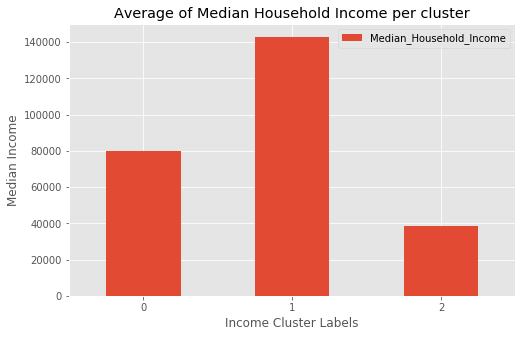

In [28]:
cluster_avg = df_combined.groupby(['Income Cluster Labels']).mean()
ax = cluster_avg.plot(kind='bar',y=['Median_Household_Income'],rot=0,figsize=(8,5))
ax.set_ylabel('Median Income')
ax.set_title('Average of Median Household Income per cluster')

### Let's also Cluster the data by density of the population i.e. population per square mile

In [29]:
# set number of clusters
kclusters = 3

df_pop_density = df_combined['Pop_SqMi'].to_frame()

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(df_pop_density)

In [30]:
kmeans.labels_

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,

In [31]:
df_combined.insert(0,"PopDensity Cluster Labels", kmeans.labels_)

Let's look at the density of population on the map

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, popd in zip(df_combined['Latitude'], df_combined['Longitude'], df_combined['geoname'], df_combined['PopDensity Cluster Labels'], df_combined['Pop_SqMi']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Pop Density ' + str(popd), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

In [33]:
map_clusters

![Charlotte Map](img/m3.png)

Let's see the average population density per cluster.

Text(0.5, 1.0, 'Average population density per cluster')

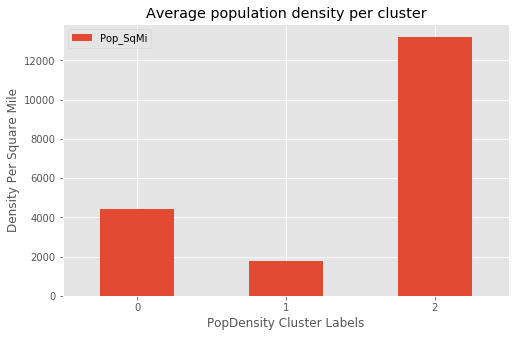

In [34]:
cluster_avg = df_combined.groupby(['PopDensity Cluster Labels']).mean()
ax = cluster_avg.plot(kind='bar',y=['Pop_SqMi'],rot=0,figsize=(8,5))
ax.set_ylabel('Density Per Square Mile')
ax.set_title('Average population density per cluster')

### Enrich data with Foursquare data

In [35]:
import os 

CLIENT_ID = os.environ['CLIENT_ID'] 
CLIENT_SECRET = os.environ['CLIENT_SECRET']
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['geoname', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Sometimes Foursquare API calls fail due to Rate limits. For repeatability I have a csv file with the same data.

In [37]:
# charlotte_venues = getNearbyVenues(names=df_combined['geoname'],
#                                    latitudes=df_combined['Latitude'],
#                                    longitudes=df_combined['Longitude']
#                                   )

If our Foursquare API calls fail to collect all the data due to Rate limits

In [38]:
charlotte_venues = pd.read_csv('charlotte_venues.csv',index_col=['Unnamed: 0'])

In [39]:
charlotte_venues.head()

geoname  Neighborhood Latitude  \
0  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   
1  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   
2  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   
3  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   
4  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   

   Neighborhood Longitude             Venue  Venue Latitude  Venue Longitude  \
0              -80.841703       Duck Donuts       35.202624       -80.844419   
1              -80.841703       Bakersfield       35.202040       -80.844430   
2              -80.841703  Dolce Ristorante       35.202836       -80.844343   
3              -80.841703           Be Yoga       35.202610       -80.844875   
4              -80.841703     Harris Teeter       35.203562       -80.845130   

       Venue Category  
0              Bakery  
1  Mexican Restaurant  
2  Italian Restaurant  
3         Yoga Studio  
4         Supermarket

## Methodology <a name="methodology"></a>

The first step of our methodology was to collect location, demographic, income and venues data for the City of Charlotte. We have collected and preprocessed the data as a first step. We'll segment the data set two different ways by Kmeans clustering. The first clustering method will be by Household Median income and the second will be based on population density per Census block i.e. population per square mile. Afterwards we'll use the clusters to create Wordclouds of the venues categories by cluster. This will show us what kind of venues are near each type of population area and help us gain better understanding about the City of Charlotte.  

## Analysis <a name="analysis"></a>

Let's create a wordcloud for the clusters to easily visualize the popularity of venues per cluster

In [40]:
from wordcloud import WordCloud, STOPWORDS

### Let's look at the venues per income cluster

In [41]:
charlotte_merged = charlotte_venues.merge(df_combined[['Income Cluster Labels','geoname']],on=['geoname'])

In [42]:
stopwords = set(STOPWORDS)
#stopwords.add("Restaurant")

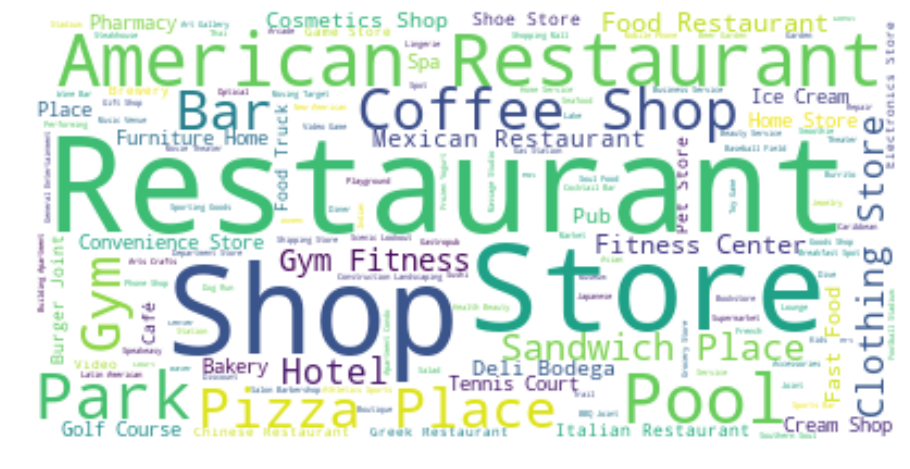

In [43]:
c0 = charlotte_merged[charlotte_merged['Income Cluster Labels'] == 0]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c0))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

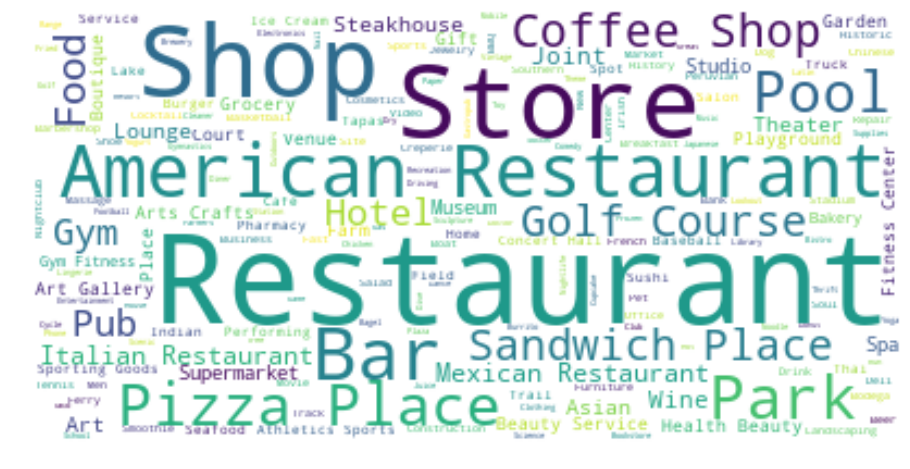

In [44]:
c1 = charlotte_merged[charlotte_merged['Income Cluster Labels'] == 1]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c1))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

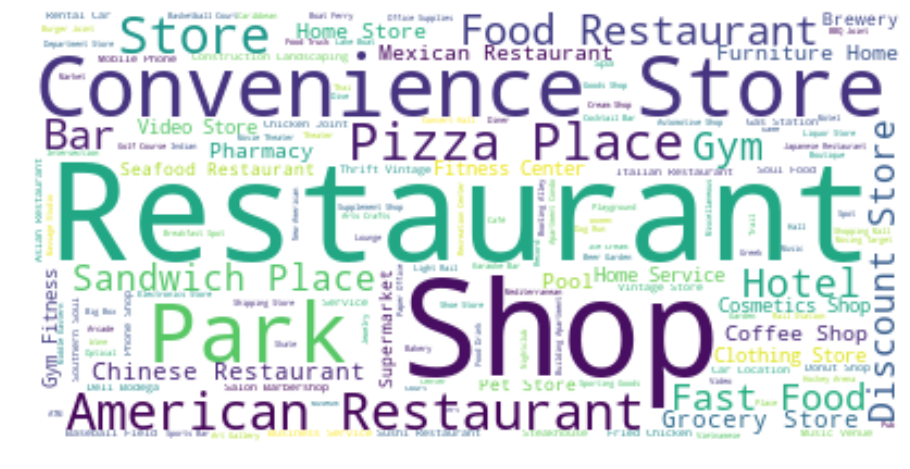

In [45]:
c2 = charlotte_merged[charlotte_merged['Income Cluster Labels'] == 2]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c2))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Let's look at the data for each Population Density Cluster

In [46]:
charlotte_merged = charlotte_venues.merge(df_combined[['PopDensity Cluster Labels','geoname']],on=['geoname'])

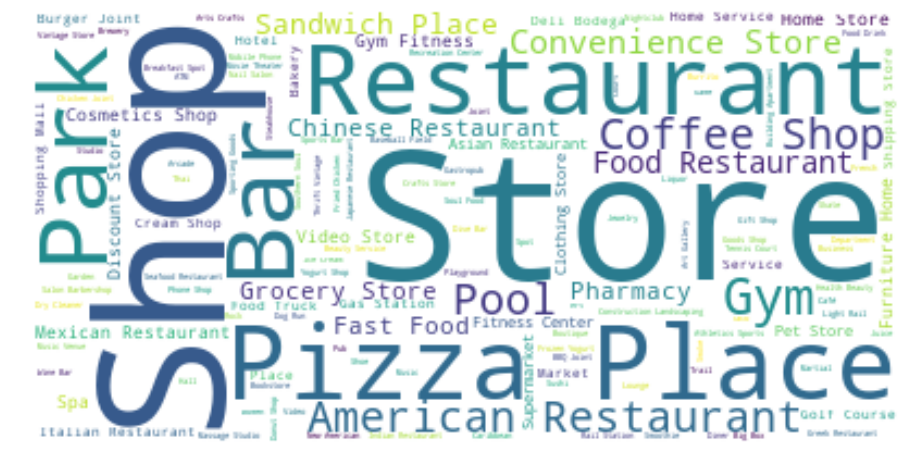

In [47]:
c0 = charlotte_merged[charlotte_merged['PopDensity Cluster Labels'] == 0]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c0))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

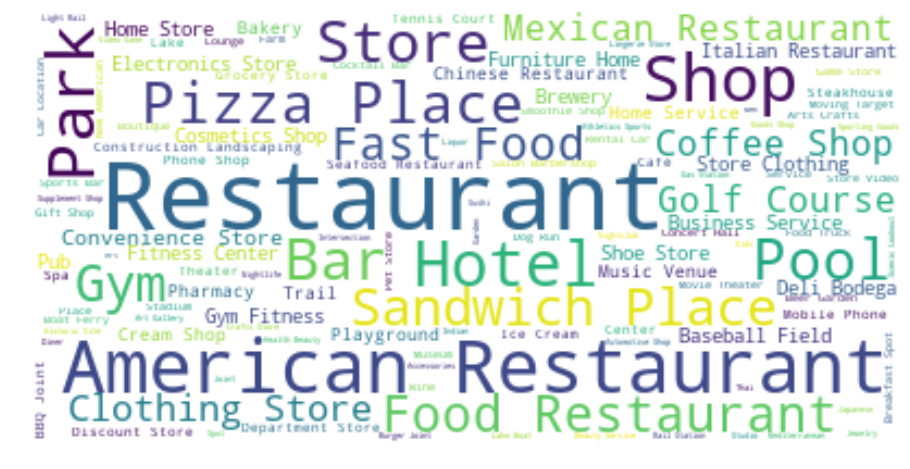

In [48]:
c1 = charlotte_merged[charlotte_merged['PopDensity Cluster Labels'] == 1]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c1))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

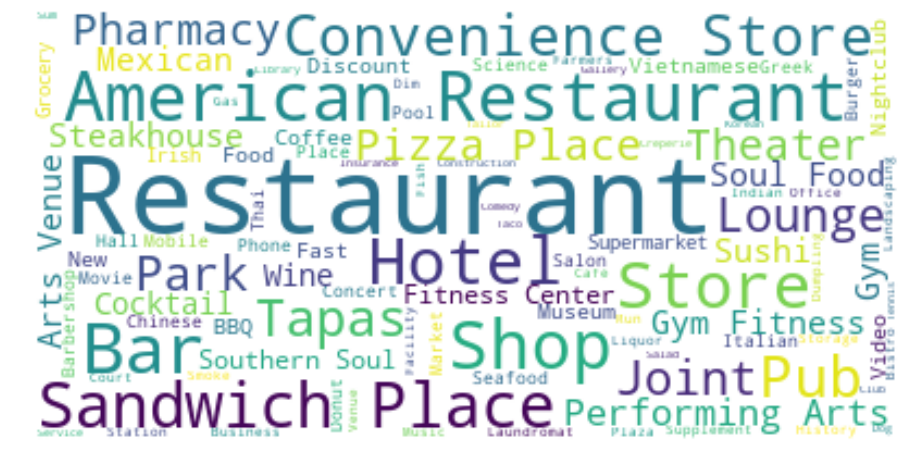

In [49]:
c2 = charlotte_merged[charlotte_merged['PopDensity Cluster Labels'] == 2]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c2))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Results <a name="results"></a>

We were able to segment the City of Charlotte into 3 clusters by income and population density. We observe the following trends based on each clustering method:

**Income Clusters**

1. Cluster Label 0 - Households with average income of 80,000. This is probably what we may call "Middle Income". We see that the venues near this group feature American and other Restaurants, Shopping, Stores, Coffee shops, Bar, Parks, Pools and Gyms.


2. Cluster Label 1 - Households with average income of above 140,000. We'll call this group "Upper Income". We see that the venues near this cluster group feature similar venues as Cluster 1, but we also see that we have Gold Courses near those households


3. Cluster Label 2 - Household with average income of 40,000. We'll call this group "Lower Income". We see that Restaurants are still prominent, but American Restaurants are not as popular there. We see a lot of Convenience stores, Shopping and Parks, but also Fast Food places. 



**Population Density Clusters**

1. Cluster Label 0 - Medium Population Density with an average of around 4,000 per square mile. We see a very strong trend for Shops, Stores and Pizza Places and fewer other venues comparitively.


2. Cluster Label 1 - Low Population Density with an average of less than 2,000 per square mile. There is a better mix of venues in this cluster featuring Restaurants, Shopping, Hotels, Sandwitch Places, Fast Food and Parks.


3. Cluster Label 2 - High Population Density with an average of close to 13,000 per square mile. This group features a lot more venues which we have not seen previously like Performing Arts, Theatre, Soul food, Arts Venue in addition to what we have learned to expect i.e. Restaurants and Shops. 


## Conclusion <a name="conclusion"></a>

Our investigation in the City of Charlotte revealed some interesting, but probably expected results. We can find American Restaurants almost anywhere in the city. Other Restaurants and Shopping is also easy to come by. We find more Fast Food places and Convenience Stores compared to other venues in lower income areas of the city. We also do see the highest variety of venues and entertainment in the very high population density areas of the city i.e. downtown. 

This notebook shows just 2 of the clustering methods, but many more are possible with the available information.